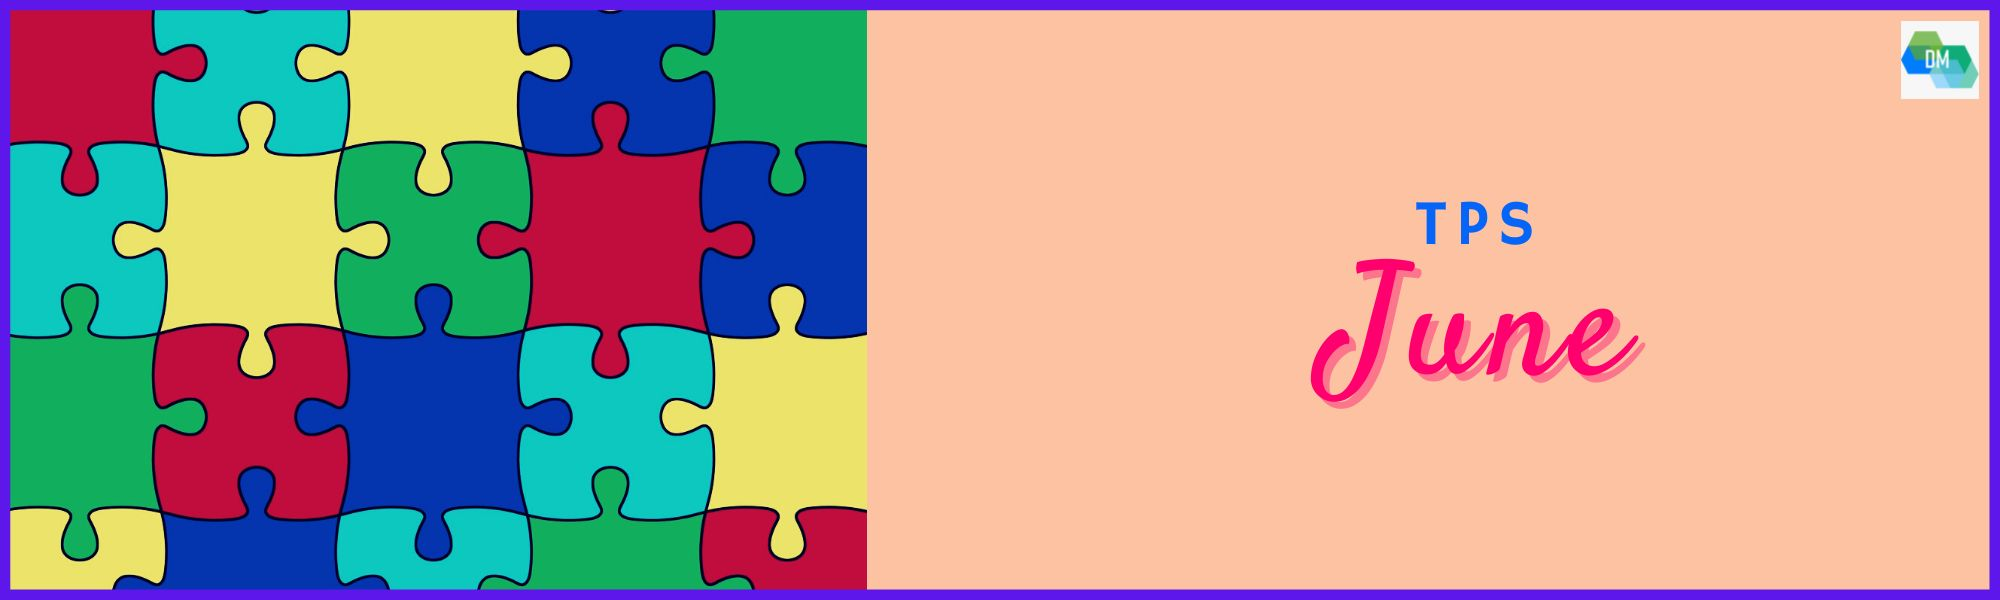

<p style="font-family: Arials; font-size: 20px;text-align: center;; font-style: normal;line-height:1.3">For this challenge, you are given (simulated) manufacturing control data that contains missing values due to electronic errors. Your task is to predict the values of all missing data in this dataset.</p>

**Observations on this TPS dataset:**
- The dataset has `10,00,000` rows and `80` columns 
- The dataset contains`4` features categories - `F_1`,`F_2`,`F_3` and `F_4`
- `F_1` and `F_4` are divided into `15` features while `F_2` and `F_3` are divided into `25` features.
- `25` features are `int` type and `55` features are `float` type
- We have to fill the missing values. But not all the columns have missing values.

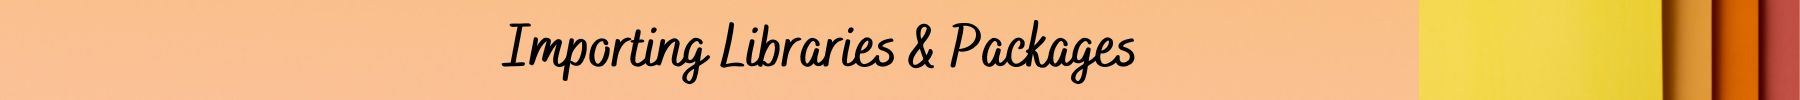

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import gc
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from tqdm.notebook import tqdm
from xgboost import XGBRegressor

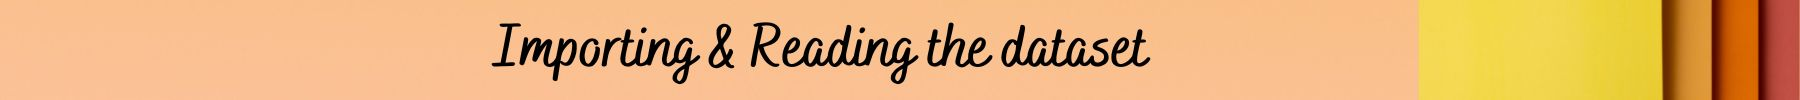

In [2]:
df_data = pd.read_csv('../input/tabular-playground-series-jun-2022/data.csv', index_col='row_id')
df_subm =  pd.read_csv('../input/tabular-playground-series-jun-2022/sample_submission.csv', index_col='row-col')

In [3]:
df_data_row_count, df_data_column_count = df_data.shape
print('Total number of rows:', df_data_row_count) 
print('Total number of columns:', df_data_column_count)

Total number of rows: 1000000
Total number of columns: 80


In [4]:
df_data.head()

,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,...,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
row_id,,,,,,,,,,,,,,,,,,,,,
0,-0.354591,-0.464038,2.304115,0.734486,1.696395,0.136285,-0.518344,0.502640,-1.852504,-0.500665,...,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,1.380940,-0.499626,-0.418548,1.911725,-0.826130,-1.715371,-0.577091,-1.041486,0.596067,-0.363425,...,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,0.256023,-1.059874,NaN,0.345678,1.513814,1.243864,-0.509648,-0.800481,-0.115945,0.595777,...,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,-0.728420,-2.432399,-2.453602,-0.020509,0.333397,0.086049,-1.787601,0.667011,0.761564,-2.217847,...,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,0.590212,-0.066127,0.468009,-1.096038,0.119399,-1.809710,0.466358,-0.053196,-0.580320,-1.143500,...,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943


In [5]:
df_data.describe().T

,count,mean,std,min,25%,50%,75%,max
F_1_0,981603.0,-0.000687,1.000784,-4.664447,-0.674667,-0.000769,0.673181,5.039177
F_1_1,981784.0,0.002091,0.999878,-4.790594,-0.672284,0.002049,0.675997,5.042807
F_1_2,981992.0,0.000551,0.999825,-4.870645,-0.673783,0.001386,0.674490,5.130025
F_1_3,981750.0,0.000982,0.999847,-5.053023,-0.672211,0.000370,0.674852,5.462472
F_1_4,981678.0,0.002437,1.001151,-5.363454,-0.672326,0.002733,0.676588,4.856916
...,...,...,...,...,...,...,...,...
F_4_10,981775.0,0.038282,0.706913,-10.353951,-0.385768,0.102679,0.529550,2.548404
F_4_11,981881.0,0.551900,4.996632,-26.276588,-2.791428,0.203056,3.646324,31.229363
F_4_12,981694.0,0.333509,2.383485,-11.524137,-1.268732,0.354137,1.947385,11.341926
F_4_13,982005.0,0.330047,2.364036,-10.661978,-1.298927,0.295049,1.916931,11.901409


In [6]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 80 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   F_1_0   981603 non-null   float64
 1   F_1_1   981784 non-null   float64
 2   F_1_2   981992 non-null   float64
 3   F_1_3   981750 non-null   float64
 4   F_1_4   981678 non-null   float64
 5   F_1_5   981911 non-null   float64
 6   F_1_6   981867 non-null   float64
 7   F_1_7   981872 non-null   float64
 8   F_1_8   981838 non-null   float64
 9   F_1_9   981751 non-null   float64
 10  F_1_10  982039 non-null   float64
 11  F_1_11  981830 non-null   float64
 12  F_1_12  981797 non-null   float64
 13  F_1_13  981602 non-null   float64
 14  F_1_14  981961 non-null   float64
 15  F_2_0   1000000 non-null  int64  
 16  F_2_1   1000000 non-null  int64  
 17  F_2_2   1000000 non-null  int64  
 18  F_2_3   1000000 non-null  int64  
 19  F_2_4   1000000 non-null  int64  
 20  F_2_5   1000000 non-null 

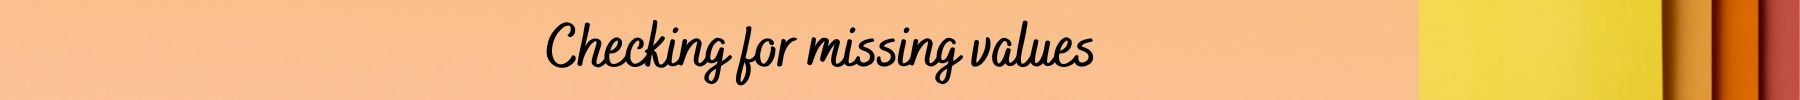

In [7]:
df_data.isna().sum()

F_1_0     18397
F_1_1     18216
F_1_2     18008
F_1_3     18250
F_1_4     18322
          ...  
F_4_10    18225
F_4_11    18119
F_4_12    18306
F_4_13    17995
F_4_14    18267
Length: 80, dtype: int64

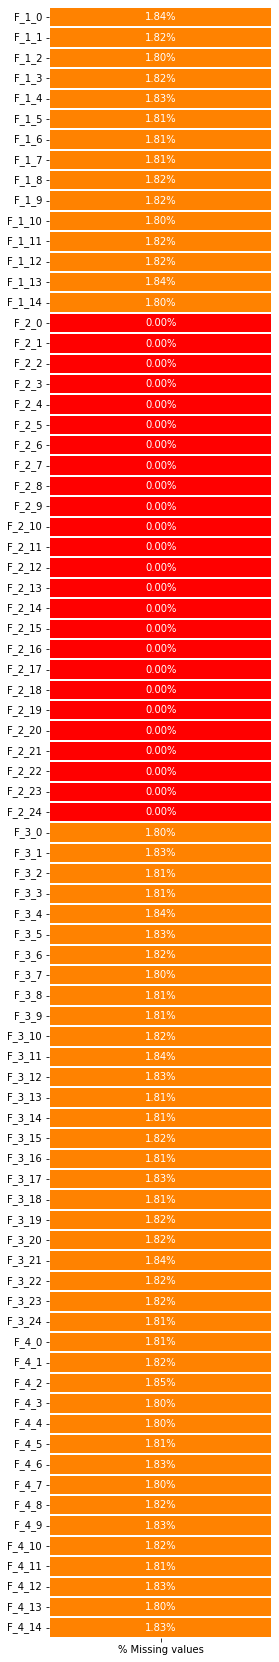

In [8]:
background_color = 'white'
missing = pd.DataFrame(columns=['% Missing values'],data=df_data.isnull().sum()/len(df_data))
fig = plt.figure(figsize=(10, 30),facecolor=background_color)
gs = fig.add_gridspec(1, 2)
gs.update(wspace=0.5, hspace=0.5)
ax0 = fig.add_subplot(gs[0, 0])
for s in ["right", "top","bottom","left"]:
    ax0.spines[s].set_visible(False)
sns.heatmap(missing,cbar=False,annot=True,fmt=".2%", linewidths=2,cmap="prism",vmax=1, ax=ax0)
plt.show()

In [9]:
features = list(df_data.columns)
features = features[1:len(features)]
F1_features = [feat for feat in features if feat[:3] == "F_1"]
F2_features = [feat for feat in features if feat[:3] == "F_2"]
F3_features = [feat for feat in features if feat[:3] == "F_3"]
F4_features = [feat for feat in features if feat[:3] == "F_4"]

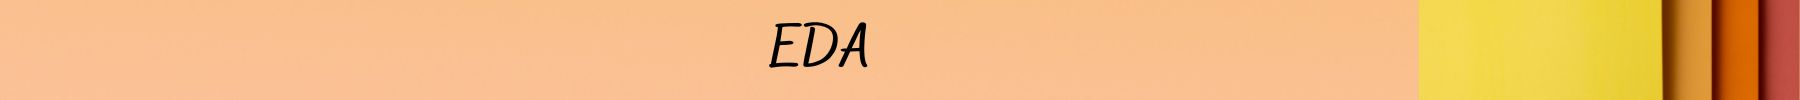

## Features F_1 

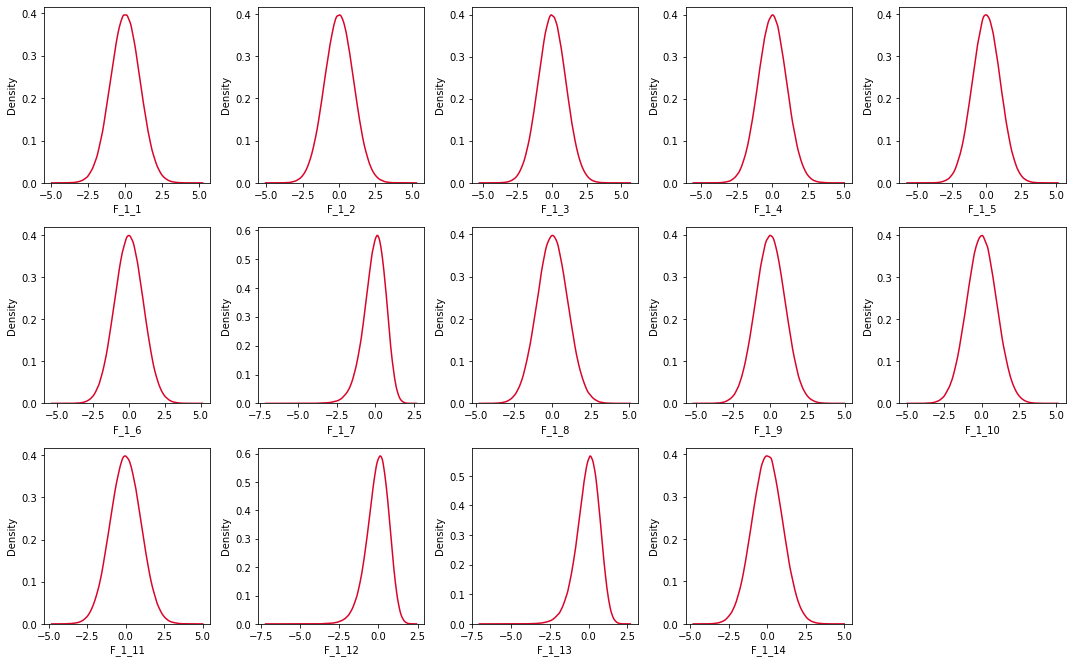

In [10]:
plt.figure(figsize=(15,15))
for i, f in enumerate(F1_features):
    plt.subplot(5, 5, i+1)
    axs = sns.kdeplot(x = df_data[f],color="#d90429")
plt.tight_layout()
plt.show()

## Features F_2

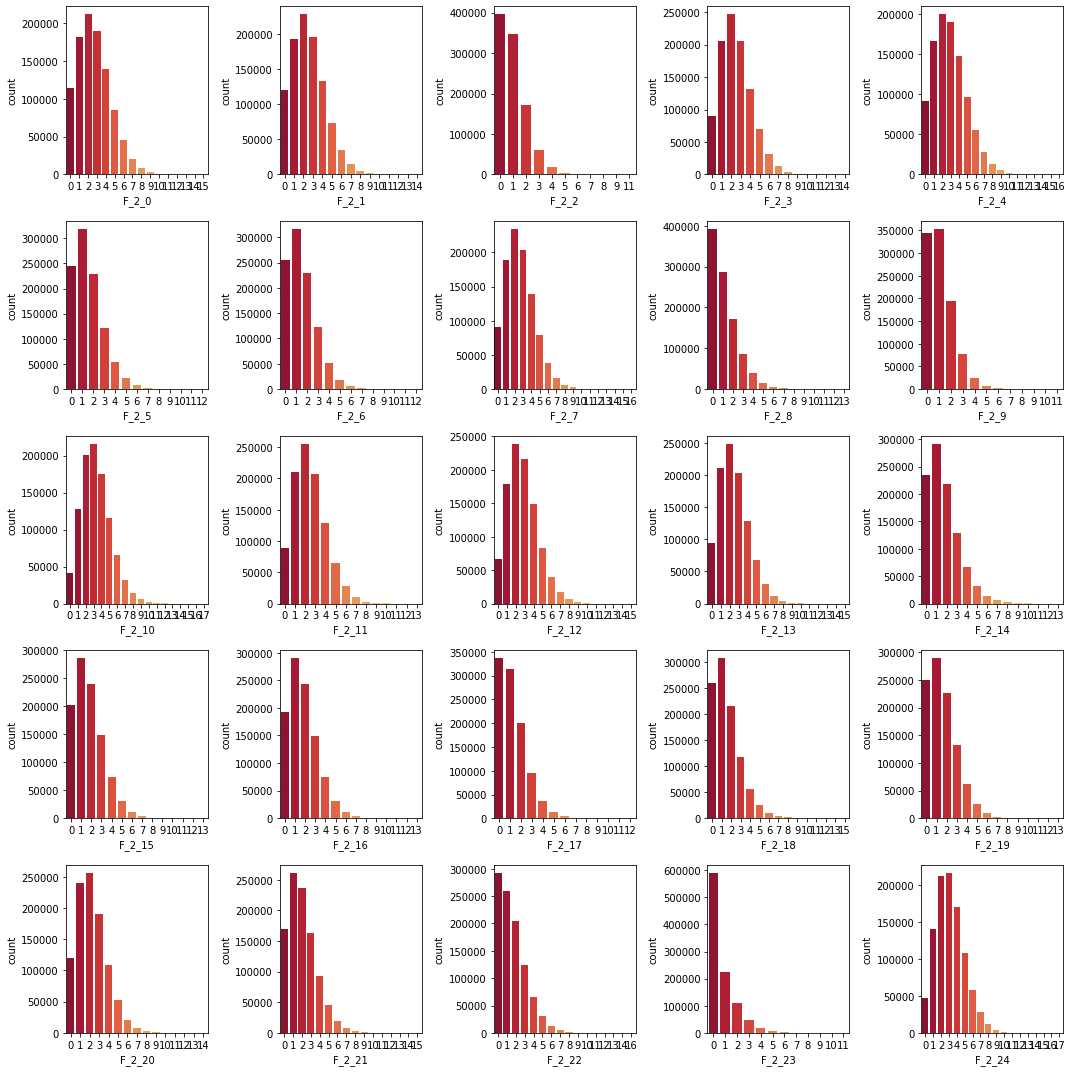

In [11]:
plt.figure(figsize=(15,15))
for i, f in enumerate(F2_features):
    plt.subplot(5, 5, i+1)
    axs = sns.countplot(x = df_data[f],palette="YlOrRd_r")
plt.tight_layout()
plt.show()

## Features F_3

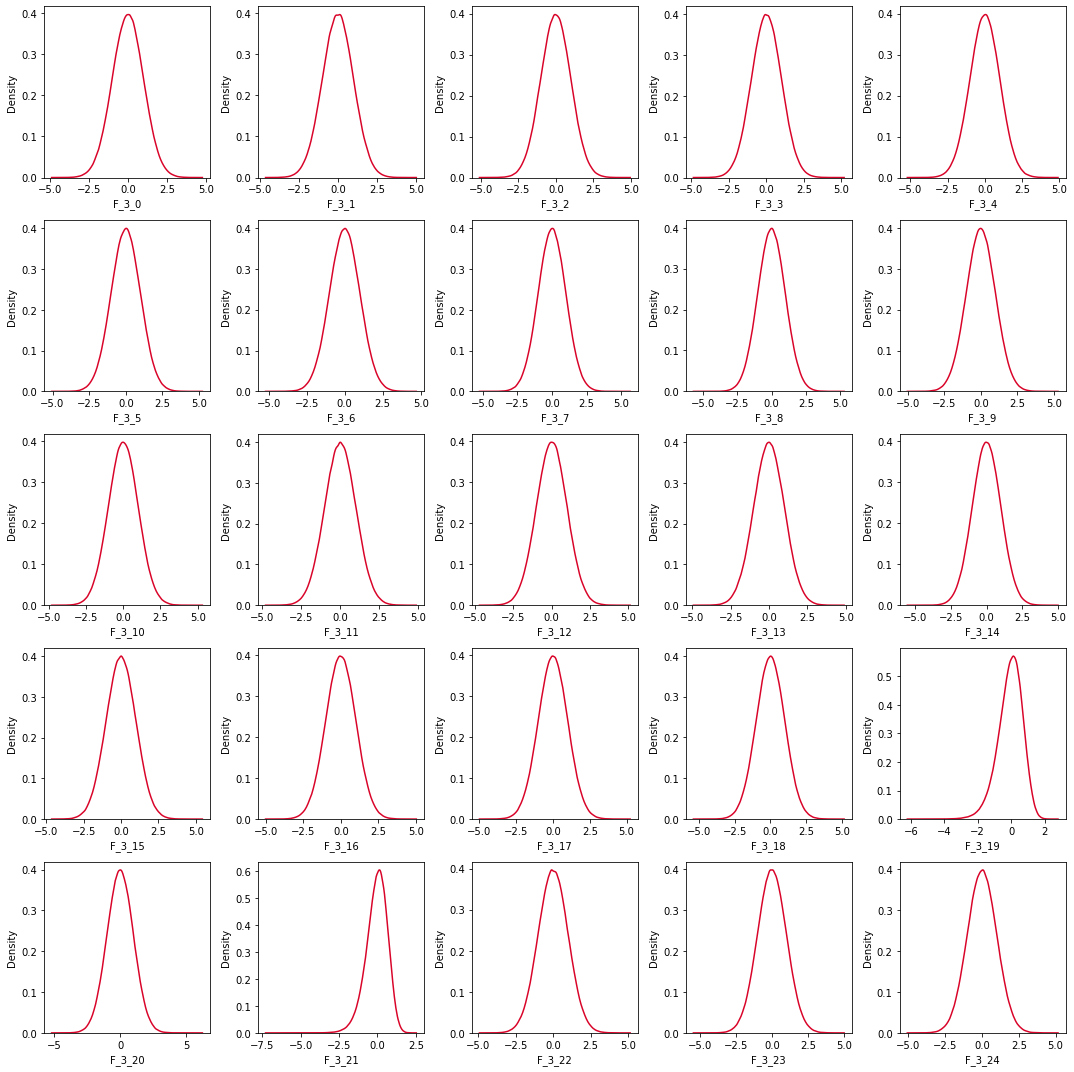

In [12]:
plt.figure(figsize=(15,15))
for i, f in enumerate(F3_features):
    plt.subplot(5, 5, i+1)
    axs = sns.kdeplot(x = df_data[f],color="#d90429")
plt.tight_layout()
plt.show()

## Features F_4

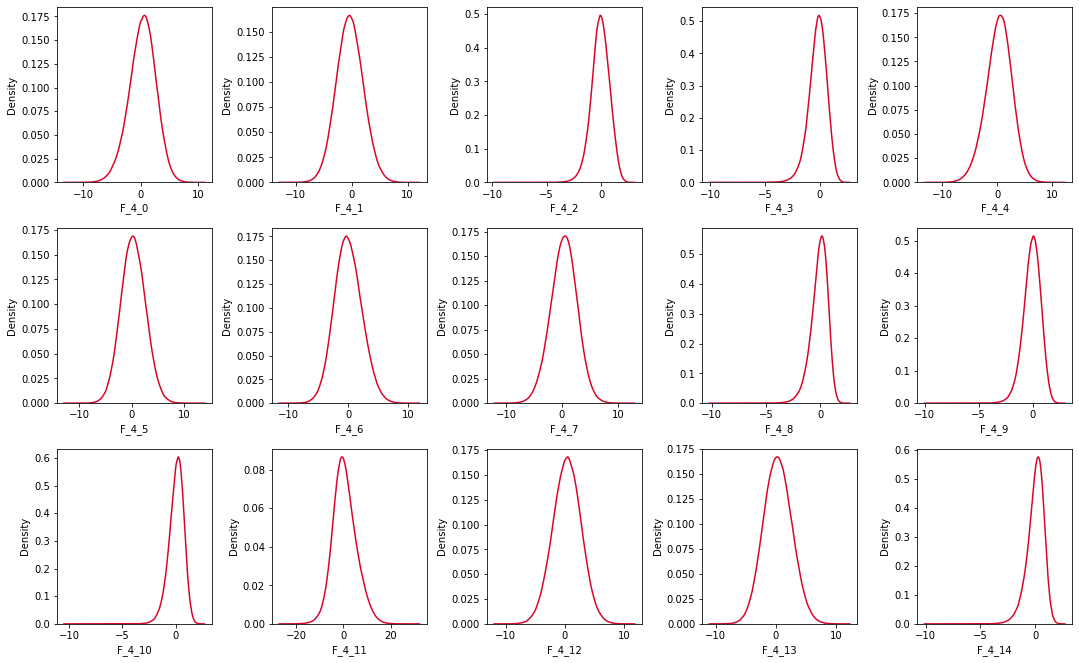

In [13]:
plt.figure(figsize=(15,15))
for i, f in enumerate(F4_features):
    plt.subplot(5, 5, i+1)
    axs = sns.kdeplot(x = df_data[f],color="#d90429")
plt.tight_layout()
plt.show()

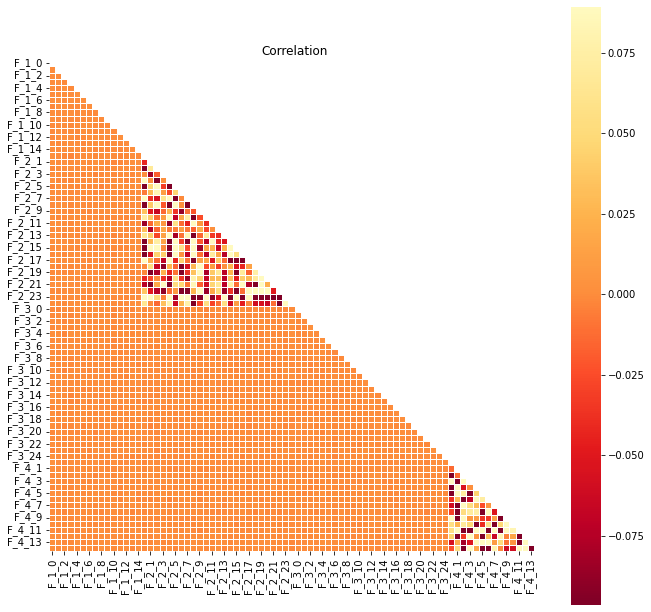

In [14]:
plt.figure(figsize=(11,11))
corr=df_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, robust=True, center=0,square=True, linewidths=.6,cmap='YlOrRd_r')
plt.title('Correlation')
plt.show()

In [15]:
gc.collect()

10935

In [16]:
df_data1 = df_data.copy()

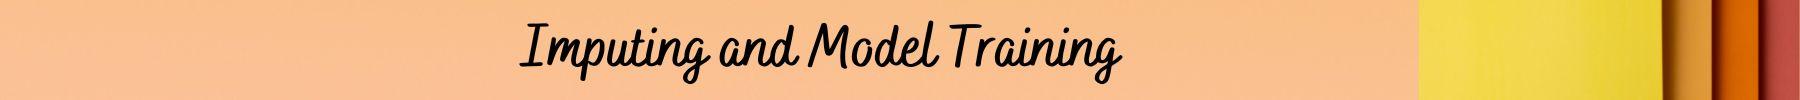

In [17]:
F4_feat = [col for col in df_data1.columns if col.split('_')[1] == '4']
df_new = pd.DataFrame()
for feature in df_data1.columns:
    if feature in F4_feat:
        df_new[feature] = df_data1[feature]
F123_features = df_data1.drop(F4_feat, axis=1)

In [18]:
feat_imp = SimpleImputer(missing_values=np.nan, strategy= 'mean')
imp = pd.DataFrame(feat_imp.fit_transform(F123_features), columns = F123_features.columns)

In [19]:
for column in df_new.columns:
    df_train = df_new[df_new[column].isna() == False]
    df_test = df_new[df_new[column].isna() == True]
    
    X = df_train.drop(column, axis=1)
    y = df_train[column]
    
    model = XGBRegressor(random_state=123, n_estimators= 3000, booster='gbtree',verbosity = 2,tree_method = 'gpu_hist')
    model.fit(X, y)
    
    pred = model.score(X, y)
    df_new[column][df_test.index] = model.predict(df_test.drop(column, axis = 1))

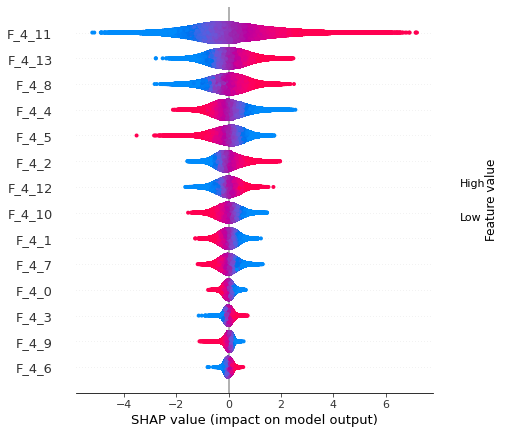

In [20]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values,max_display = 20)

In [21]:
df = pd.concat([imp, df_new], axis = 1)

In [22]:
for i in tqdm(df_subm.index):
    row = int(i.split('-')[0])
    col = i.split('-')[1]
    df_subm.loc[i, 'value'] = df.loc[row, col]
df_subm.to_csv('submission_xgb.csv')
df_subm

  0%|          | 0/1000000 [00:00<?, ?it/s]

,value
row-col,
0-F_1_14,-0.000905
0-F_3_23,0.000365
1-F_3_24,-0.000817
2-F_1_2,0.000551
2-F_4_2,0.383486
...,...
999993-F_4_2,-0.262320
999994-F_3_10,0.001706
999994-F_4_9,-0.178212


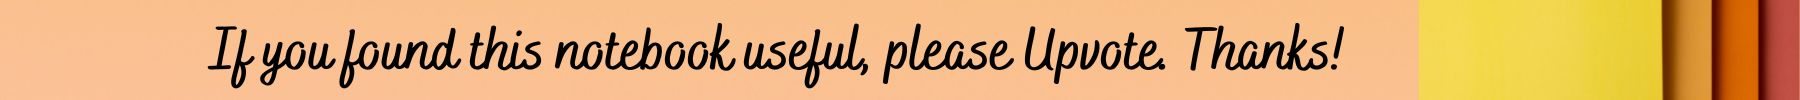